## ECMWF Ensemble Risk Analysis ##

#### Setup Program Libraries ####

In [1]:
# INITIALIZING LIBRARIES

# The following libraries are used as part of this project

# data modules
import pandas as pd
from cfgrib.xarray_store import open_dataset
import xarray as xr
import numpy as np


# data aggregation libraries
import ecmwf.data as ecdata
from ecmwf.opendata import Client
from pathlib import Path

# plotting modules
from magpye import GeoMap
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import figure
import matplotlib.pyplot as plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 

# statistical packages
from scipy.signal import savgol_filter
import xarray.ufuncs as xu
import scipy.stats as stats

# climatology packages using meteostat
from meteostat import Point
from meteostat import Stations, Daily, Hourly

# misc packages
from prettytable import PrettyTable
import datetime
from datetime import datetime
from os.path import dirname, join
import time
from IPython.display import HTML, display
from cartopy.util import add_cyclic_point

In [2]:
########################################## User Input To Initialze Model #######################################

# Weather parameter input
user_input_wx_var = 'surface_temp'

# Location input
user_input_loc = 'Des Moines'

# Forecast parameters input
fct_start = 0
fct_end = 300
fct_int = 6

### Dictionaries for site locations and weather forecast parameters ###
 
##### A dictionary of all the lat/lon points for each forecast location are provided - there are 21 in total. Additionally, the weather variables are provided for data aggregation. Variables include surface temperature, surface pressure (MSLP), total column water vapor (proxy for precip), surface wind (u & v components), and 500mb heights #####

In [3]:
# Dictionary of cities - this includes lat/lon, city name and title for each location

cities = {
    'Boston': {
        'latitude': 42.090925,
        'longitude': -71.26435,
        'city_name' : 'Boston',
        'title': 'Boston, MA',
        
    },
    'Chicago': {
        'latitude': 41.862306,
        'longitude': -87.616672,
        'city_name' : 'Chicago',
        'title': 'Chicago, IL',
    },
    'New York': {
        'latitude': 40.812194,
        'longitude': -74.076983,
        'city_name' : 'New York',
        'title': 'New York, NY',
    },
    'Buffalo': {
        'latitude': 42.773739,
        'longitude': -78.786978,
        'city_name' : 'Buffalo',
        'title': 'Buffalo, NY',
    },
    'Pittsburg': {
        'latitude': 40.446786,
        'longitude': -80.015761,
        'city_name' : 'Pittsburg',
        'title': 'Pittsburg, PA',
    },
    'Philadelphia': {
        'latitude': 39.900775,
        'longitude': -75.167453,
        'city_name' : 'Philadelphia',
        'title': 'Philadelphia, PA',
    },
    'Cleveland': {
        'latitude': 41.506022,
        'longitude': -81.699564,
        'city_name' : 'Cleveland',
        'title': 'Cleveland, OH',
    },
    'Cincinnati': {
        'latitude': 39.095442,
        'longitude': -84.516039,
        'city_name' : 'Cincinnati',
        'title': 'Cincinnati, OH',
    },
    'Washington DC': {
        'latitude': 38.907697,
        'longitude': -76.864517,
        'city_name' : 'Washington DC',
        'title': 'Washington DC',
    },
    'Baltimore': {
        'latitude': 39.277969,
        'longitude':-76.622767,
        'city_name' : 'Baltimore',
        'title': 'Baltimore, MD',
    },
    'Nashville': {
        'latitude': 36.166461,
        'longitude':-86.771289,
        'city_name' : 'Nashville',
        'title': 'Nashville, TN',
    },
    'Charlotte': {
        'latitude': 35.225808,
        'longitude': -80.852861,
        'city_name' : 'Charlotte',
        'title': 'Charlotte, NC',
    },
    'Jacksonville': {
        'latitude': 30.323925,
        'longitude': -81.637356,
        'city_name' : 'Jacksonville',
        'title': 'Jacksonville, FL',
    },
    'Tampa Bay': {
        'latitude':27.975967,
        'longitude': -82.50335,
        'city_name' : 'Tampa Bay',
        'title': 'Tampa Bay, FL',
    },
    'Miami': {
        'latitude': 25.957919,
        'longitude': -80.238842,
        'city_name' : 'Miami',
        'title': 'Miami, FL',
    },
    'Green Bay': {
        'latitude': 44.501306,
        'longitude': -88.062167,
        'city_name' : 'Green Bay',
        'title': 'Green Bay, WI',
    },
    'Kansas City': {
        'latitude': 39.048914,
        'longitude': -94.484039,
        'city_name' : 'Kansas City',
        'title': 'Kansas City, MO',
    },
    'Denver': {
        'latitude': 39.743936,
        'longitude': -105.020097,
        'city_name' : 'Denver',
        'title': 'Denver, CO',
    },
    'Seattle': {
        'latitude': 47.595153,
        'longitude': -122.331625,
        'city_name' : 'Seattle',
        'title': 'Seattle, WA',
    },
    'San Francisco': {
        'latitude': 37.713486,
        'longitude':-122.386256,
        'city_name' : 'San Francisco',
        'title': 'San Francisco, CA',
    },
    'Des Moines': {
        'latitude': 41.5868,
        'longitude':-93.6250,
        'city_name' : 'Des Moines',
        'title': 'Des Moines, IA',
    },
    
}

# Dictionary of weather variables - this includes weather variable and abbreviations

wx_variables = {
    'surface_temp': {
        'var_name' : '2t',
        'ec_name' : 't2m',
        'ec_name_2': 't2m',
    },
    'surface_wind':{
        'var_name_u': '10u',
        'ec_name_u': 'u10',
        'var_name_v': '10v',
        'ec_name_v': 'v10',
        'var_name': 'wind_speed',
        'ec_name_2': 'result_wind',
    },
    'surface_pressure': {
        'var_name' : 'msl',
        'ec_name' : 'msl',
        'ec_name_2': 'msl',
    },
    'precipitation': {
        'var_name' : 'tcwv', # total column water vapor
        'ec_name' : 'tcwv',
        'ec_name_2': 'tcwv',
    },
    'height500': {
        'var_name' : 'gh', 
        'ec_name' : 'gh',
        'ec_name_2': 'gh',
    },
}

# initialize parameters for data download from ECMWF Server

if user_input_wx_var == 'surface_temp':
    parameters = ['{}'.format(wx_variables[user_input_wx_var]['var_name'])]
    wx_var = wx_variables[user_input_wx_var]['var_name']
    filename = 'medium-fct-{}.grib'.format(wx_variables[user_input_wx_var]['var_name'])
    
elif user_input_wx_var == 'surface_pressure':
    parameters = ['{}'.format(wx_variables[user_input_wx_var]['var_name'])]
    wx_var = wx_variables[user_input_wx_var]['var_name']
    filename = 'medium-fct-{}.grib'.format(wx_variables[user_input_wx_var]['var_name'])

elif user_input_wx_var == 'precipitation':
    parameters = ['{}'.format(wx_variables[user_input_wx_var]['var_name'])]
    wx_var = wx_variables[user_input_wx_var]['var_name']
    filename = 'medium-fct-{}.grib'.format(wx_variables[user_input_wx_var]['var_name'])

elif user_input_wx_var == 'height500':
    parameters = ['{}'.format(wx_variables[user_input_wx_var]['var_name'])]
    wx_var = wx_variables[user_input_wx_var]['var_name']
    filename = 'medium-fct-{}.grib'.format(wx_variables[user_input_wx_var]['var_name'])

elif user_input_wx_var == 'surface_wind':
    parameters = ['{}'.format(wx_variables[user_input_wx_var]['var_name_u']), 
                '{}'.format(wx_variables[user_input_wx_var]['var_name_v'])]
    wx_var = wx_variables[user_input_wx_var]['var_name']
    filename = 'medium-fct-{}.grib'.format(wx_variables[user_input_wx_var]['var_name'])

print(parameters) 

['2t']


#### Data Aggregation and Cleaning ####

In [4]:
# forecast range initialization
steps = list(range(fct_start,fct_end,fct_int))


# Aggregate ECMWF Data using ecmwf.opendata package. This is downloaded using the following parameterizations 
if user_input_wx_var != 'height500':
    client = Client("ecmwf", beta=True)
    client.retrieve(
        area= 50/-135/-60/-30, #North/West/South/East.
        grid=0.5/0.5, # 0.5 spatial resolutions
        step = steps, # forecast step and duration (i.e. 6-hourly up to 300 hr forecast)
        stream="enfo",
        type=['cf', 'pf'], # download operational and all 50 ensemble means
        levtype="sfc", # atmospheric level for downolad
        param=parameters, #  atmospheric parameter model output
        target=filename # file name for download
    )

 # This is similar to the initization above, but this verison is for the 500mb layer (500mb heights)   
elif user_input_wx_var == 'height500':
    client = Client("ecmwf", beta=True)
    client.retrieve(
        area= 50/-135/-60/-30, #North/West/South/East.
        grid=0.5/0.5,
        step = steps,
        stream="enfo",
        type="es",
        levtype="pl",
        levelist=[500], # 500mb layer instead of sfc
        param=parameters,
        target=filename
)


# Convert data to Xarray
data_xr = xr.open_dataset(filename, filter_by_keys={'dataType': 'pf'}, engine='cfgrib')


# Isolate data for specific lat/lon point based on user input of city location
data_xr_sel = data_xr.sel(latitude = cities[user_input_loc]['latitude'] , longitude = cities[user_input_loc]['longitude'],
                          method='nearest')


# Unit conversions for selected weather variable
if user_input_wx_var == 'surface_temp': # surface temp
   data_xr_sel_2 = ((data_xr_sel - 273.15) * 9/5) + 32

elif user_input_wx_var == 'surface_pressure': # surface pressure
   data_xr_sel_2 = (data_xr_sel/100)

elif user_input_wx_var == 'precipitation': # precipitation
   data_xr_sel_2 = data_xr_sel

elif user_input_wx_var == 'height500': # 500mb height
   data_xr_sel_2 = (data_xr_sel/10)

elif user_input_wx_var == 'surface_wind': # surface wind (u and v components)
   data_xr_sel['result_wind'] = (xu.sqrt(data_xr_sel[wx_variables[user_input_wx_var]['ec_name_u']]**2 + 
                           data_xr_sel[wx_variables[user_input_wx_var]['ec_name_v']]**2)) *2.237
   data_xr_sel_2 = data_xr_sel


# data_xr_sel_2 is the dataset that will be utilized by the below program
data_xr_sel_2

MARS post-processing keywords {'area', 'grid'} not supported


<multiple>:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

<xarray.Dataset>
Dimensions:            (number: 50, step: 50)
Coordinates:
  * number             (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    time               datetime64[ns] ...
  * step               (step) timedelta64[ns] 0 days 00:00:00 ... 12 days 06:...
    heightAboveGround  float64 ...
    latitude           float64 41.6
    longitude          float64 -93.6
    valid_time         (step) datetime64[ns] ...
Data variables:
    t2m                (number, step) float32 29.22 30.06 28.01 ... 19.25 15.57
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-02-23T13:28 GRIB to CDM+CF via cfgrib-0.9.1...

### CLIMATOLOGY CALCULATIONS ###
 
#### 10 and 30 year climatologies are calculated using the Meteostat Python package. Nearest station approximator is used to find observational stations closest to specific lat/lon locations. Meteostat provides surface wind, temperature, pressure, and precipitation metrics down to hourly resolution. For this project, quantities will be averaged daily. ####

In [5]:
# Weather parameter input to coincide with meteostat output

if user_input_wx_var == 'surface_temp':
    climo_indice = 'tavg'

if user_input_wx_var == 'surface_wind':
    climo_indice = 'wspd'

if user_input_wx_var == 'surface_pressure':
    climo_indice = 'pres'

if user_input_wx_var == 'precipitation':
    climo_indice = 'prcp'

In [6]:
# 10 year climo for station

# Set time period range
start = datetime(2011, 1, 1)
end = datetime(2021, 12, 31)

# locate stations near lat/lon point
stations = Stations()
stations = stations.nearby(cities[user_input_loc]['latitude'],cities[user_input_loc]['longitude'])

# loop over all station outputs to find station that meets criteria
station = stations.fetch(10) # fetch closest 10 stations
for a in range(0,10,1):   
        if (station['hourly_start'].dt.year.values[a] <= 2011) & (station['hourly_end'].dt.year.values[a] >= 2021):
            print("this station works")
            station_climo = station.loc[(station.index== station.index[a])]
            break

station = station_climo.index.values[0]

# Get daily data
data_10_climo = Daily(station, start, end)
data_10_climo = data_10_climo.fetch()

# calculate climatological averages over 10-year period
time_list = []
var_list = []
for a in range(0,len(data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].valid_time)):
  time_climo = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].valid_time[a]
  day_climo = data_10_climo.loc[ (data_10_climo.index.month.values == time_climo.dt.month.values) &
                          (data_10_climo.index.day.values == time_climo.dt.day.values)
                            #(data.index.hour.values == time_climo.dt.hour.values)
                        ]
  
  # unit conversions if neccessary
  if climo_indice == 'tavg':
    day_climo.tavg = (day_climo.tavg * 9/5) + 32
    day_mean = day_climo.tavg.mean()

  if climo_indice == 'wspd':
    day_climo.wspd = (day_climo.wspd/1.609)
    day_mean = day_climo.wspd.mean()
  
  if climo_indice == 'prcp':
    day_mean = day_climo.prcp.mean()

  if climo_indice == 'pres':
    day_mean = day_climo.pres.mean()


  var_list.append(day_mean)
  time_list.append(time_climo.values)

# full 10-year climo dataset
climo_10_dataset = pd.DataFrame({'time': time_list, 'wx_var': var_list})

this station works


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
# 30 year climo for station

# Set time period
start = datetime(1991, 1, 1)
end = datetime(2021, 12, 31)

# locate stations near lat/lon point
stations = Stations()
stations = stations.nearby(cities[user_input_loc]['latitude'],cities[user_input_loc]['longitude'])

# loop over all station outputs to find station that meets criteria
station = stations.fetch(10) # fetch closest 10 stations
for a in range(0,10,1):   
        if (station['hourly_start'].dt.year.values[a] <= 1991) & (station['hourly_end'].dt.year.values[a] >= 2021):
            print("this station works")
            station_climo = station.loc[(station.index== station.index[a])]
            break

station_climo

station = station_climo.index.values[0]

# Get daily data
data_30_climo = Daily(station, start, end)
data_30_climo = data_30_climo.fetch()

# Calculate climatological means over 30-year period
time_list = []
var_list = []
std_list = []
for a in range(0,len(data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].valid_time)):
  time_climo = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].valid_time[a]
  day_climo = data_30_climo.loc[ (data_30_climo.index.month.values == time_climo.dt.month.values) &
                          (data_30_climo.index.day.values == time_climo.dt.day.values)
                            #(data.index.hour.values == time_climo.dt.hour.values)
                        ]

  # data conversions if neccessary
  if climo_indice == 'tavg':
    day_climo.tavg = (day_climo.tavg * 9/5) + 32
    day_mean = day_climo.tavg.mean()
    day_std = day_climo.tavg.std()

  if climo_indice == 'wspd':
    day_climo.wspd = (day_climo.wspd/1.609)
    day_mean = day_climo.wspd.mean()
    day_std = day_climo.wspd.std()
  
  if climo_indice == 'prcp':
    day_mean = day_climo.prcp.mean()
    day_std = day_climo.prcp.std()

  if climo_indice == 'pres':
    day_mean = day_climo.pres.mean()
    day_std = day_climo.pres.std()

  var_list.append(day_mean)
  std_list.append(day_std)
  time_list.append(time_climo.values)

# full 30-year climo dataset
climo_30_dataset = pd.DataFrame({'time': time_list, 'wx_var': var_list, 'climo_sigma': std_list})


this station works


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Data Visualizations and Analysis ##
 
#### The following section is broken into two parts. Part 1 is for the full forecast period. This means all forecast periods as part of the initialization will be considered as part of this analysis. This part focuses on time series analysis and distributions and probabilities based on ensemble member input for each time step. ####

#### Full Period Forecast and Analysis ####

In [8]:
############################### The following code is for the full forecast period #########################

###### USER INPUT NEEDED #########

# matrix for map subplots
start_plot = 10 # start time period for plot
end_plot = 20 # end time period for plot
nrows= 2 # number of rows in subplot
ncols=5 # number of columns in subplot
cell_delete = 'NaN'

qt_dims = ('number') # quantile parameter (usually over ensemble members)
qt_upper_lim = 0.9 # upper percentile range
qt_lower_lim = 0.1 # lower percentile range

fct_interval = 6 # Forecast time interval

# The following inputs are for the probability table 
data_comp_type = 'less'  # less = probability parameter less than, greater = probability parameter greater than
data_thres_val_array= [30,40,50] # Thresholds for less than or greater than. Recommended no more than 5 intervals
#data_thres_val = 32 # single data threshold

stdev_values = [0,3,5,8] # standard deviation values to quantify risk (1st number = no risk, 2nd = marginal, 3rd = elevated, 4th = significant)
spread_values = [0,6,12,18] # precentile spread values to quantify risk (1st number = no risk, 2nd = marginal, 3rd = elevated, 4th = significant)

units = 'deg. F' # units for metric specified by user

# lat/lon range for map plots
lat_range = 4
lon_range = 4

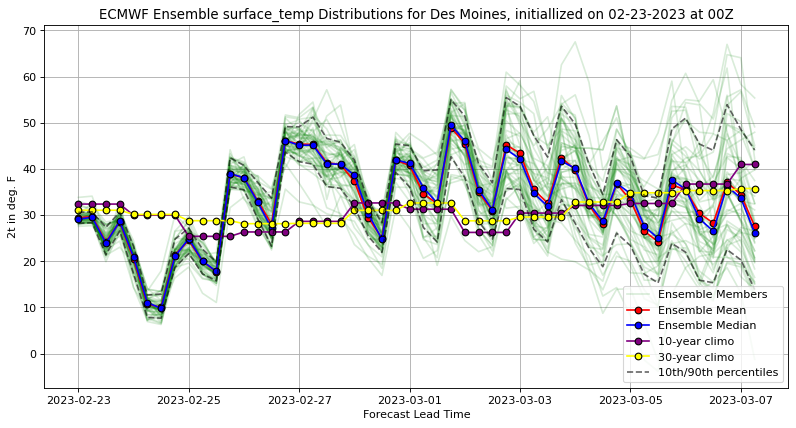

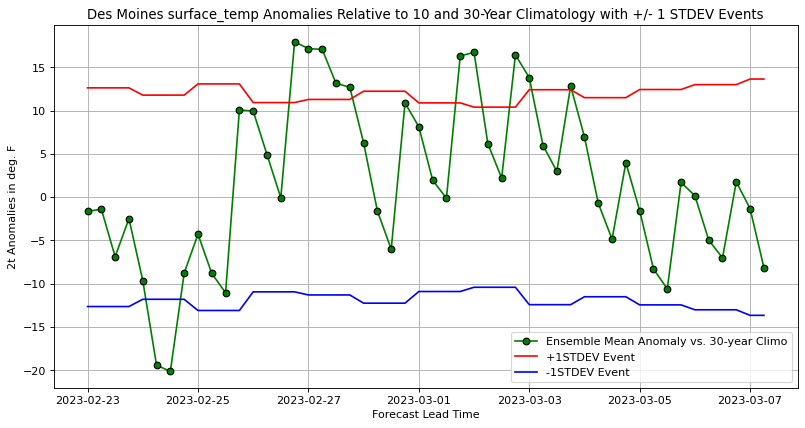

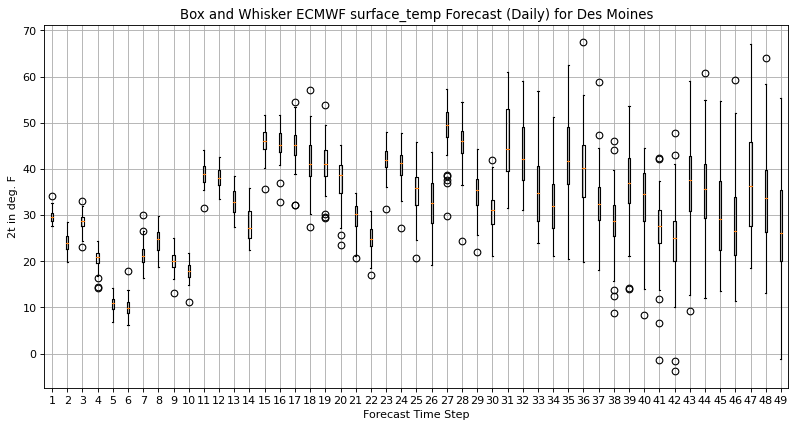

+----------+----------------------------------------+----------------------------------------+----------------------------------------+
| fct_hour | probability less than 30 deg. F as (%) | probability less than 40 deg. F as (%) | probability less than 50 deg. F as (%) |
+----------+----------------------------------------+----------------------------------------+----------------------------------------+
|    0     |                 68.17                  |                 100.0                  |                 100.0                  |
|    6     |                 60.25                  |                 100.0                  |                 100.0                  |
|    12    |                 99.71                  |                 100.0                  |                 100.0                  |
|    18    |                 78.06                  |                 100.0                  |                 100.0                  |
|    24    |                 100.0              

In [12]:
# 1) ENSEMBLE DISTRIBUTION TIME SERIES PLOT ##########################################

# All ensemble members are plotted as a time series to show ensemble distribution

# take mean of data over all ensemble members
var_mean = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].mean("number")

# take median of data over all ensemble members
var_median = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].median("number")

# identify all variable values
data_values = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].values

# identify percentile low/upper bounds
quantiles = (qt_lower_lim, qt_upper_lim)

# calculate percentiles based on ensemble distribution
ds_qt = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].quantile(quantiles, dim=qt_dims)

# time series of ensemble member distributions
figure(figsize=(12, 6), dpi=80)
#plt.grid()
for a in data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].number-1:
        fct_step = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']][a,:]
        plt.plot(data_xr_sel_2.valid_time, fct_step, color='green', alpha =0.15,label='_nolegend_')
        plt.grid()
        plt.title("ECMWF Ensemble {} Distributions for {}, initiallized on {} at {}Z".format(user_input_wx_var,user_input_loc, data_xr_sel_2.time.dt.strftime('%m-%d-%Y').values, data_xr_sel_2.time.dt.strftime('%H').values))
        plt.xlabel("Forecast Lead Time")
        plt.ylabel('{} in {}'.format(wx_variables[user_input_wx_var]['var_name'], units))

# line plot identifiers for each time period include ensemble mean, median, upper precentile, lower precentile, and ensemble members
line_member = plt.plot(data_xr_sel_2.valid_time, data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']][0,:], color='green', alpha =0.15, label = 'Ensemble Members')
line_mean = plt.plot(data_xr_sel_2.valid_time, var_mean, color='red', label = 'Ensemble Mean', marker='o', mec = 'k')
line_median = plt.plot(data_xr_sel_2.valid_time, var_median, color='blue', label = 'Ensemble Median', marker='o', mec = 'k')
line_10_climo = plt.plot(data_xr_sel_2.valid_time, climo_10_dataset['wx_var'] , color='purple', label = '10-year climo', marker='o', mec = 'k')
line_30_climo = plt.plot(data_xr_sel_2.valid_time, climo_30_dataset['wx_var'] , color='yellow', label = '30-year climo', marker='o', mec = 'k')
line_low_quant = plt.plot(data_xr_sel_2.valid_time, ds_qt[0,:], color='black', label = '_nolegend_', alpha=0.6, linestyle='dashed' )
line_up_quant = plt.plot(data_xr_sel_2.valid_time, ds_qt[1,:], color='black', label = '10th/90th percentiles', alpha=0.6, linestyle='dashed')

# plot and show graphical output
plt.grid()
plt.legend(loc ="lower right")
plt.show()



# 2) CLIMATOLOGY COMPARISON PLOT ############################
anom_var_10year = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']] - climo_10_dataset['wx_var'].values
anom_var_30year = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']] - climo_30_dataset['wx_var'].values

# identify sigma values for each day based on 30-year climo
climo_P1_event = climo_30_dataset['climo_sigma'].values
climo_M1_event = -1*(climo_30_dataset['climo_sigma'].values)

# average anomaly values over all ensemble members
var_mean_vs_10year = anom_var_10year.mean("number")
var_mean_vs_30year = anom_var_30year.mean("number")

# plot anomaly and climo indices
figure(figsize=(12, 6), dpi=80)
#plt.grid()
# line_10_year = plt.plot(data_xr_sel_2.valid_time, var_mean_vs_10year, color='purple', label = 'Ensemble Mean Anomaly vs. 10-year Climo', marker='o', mec = 'k')
line_30_year = plt.plot(data_xr_sel_2.valid_time, var_mean_vs_30year, color='green', label = 'Ensemble Mean Anomaly vs. 30-year Climo', marker='o', mec = 'k')
std_plus_1 = plt.plot(data_xr_sel_2.valid_time, climo_P1_event, color='red', label = '+1STDEV Event')
std_minus_1 = plt.plot(data_xr_sel_2.valid_time, climo_M1_event, color='blue', label = '-1STDEV Event')

plt.title("{} {} Anomalies Relative to 10 and 30-Year Climatology with +/- 1 STDEV Events".format(user_input_loc,user_input_wx_var))
plt.xlabel("Forecast Lead Time")
plt.ylabel('{} Anomalies in {}'.format(wx_variables[user_input_wx_var]['var_name'], units))

plt.grid()
plt.legend(loc ="lower right")
plt.show()




# 3) BOX AND WHISKER PLOT ###########################################
# Box and Whisker are plotted for EACH forecast period

plt.figure(figsize=(12, 6), dpi=80)
#plt.grid()
for a in range(1,len(data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].valid_time)): #data_xr_sel_2.t2m.valid_time-1:
        fct_step = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']][:,a]
        plt.boxplot((fct_step),positions = [a]) 
        plt.xlabel("Forecast Time Step")
        plt.ylabel('{} in {}'.format(wx_variables[user_input_wx_var]['var_name'], units))
        plt.title("Box and Whisker ECMWF {} Forecast (Daily) for {}".format(user_input_wx_var,user_input_loc))
plt.grid()    
plt.show()



# 4) DISTRIBUTION AND RISK TABLE #####################################
# This risk table uses the parameters input by the user in terms of thresholds for analysis
# The purpose of this table is to highlight relavent probabilities  of forecast verifying over various thresholds

probTable = PrettyTable(["fct_hour", "probability {} than {} {} as (%)".format(data_comp_type, data_thres_val_array[0], units),
                        "probability {} than {} {} as (%)".format(data_comp_type, data_thres_val_array[1], units),
                        "probability {} than {} {} as (%)".format(data_comp_type, data_thres_val_array[2], units)])
#Color
R = "\033[0;31;40m" #RED
G = "\033[0;32;40m" # GREEN
Y = "\033[0;33;40m" # Yellow
B = "\033[0;34;40m" # Blue
N = "\033[0m" # Reset

for a in range(0,len(data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].valid_time)):
    n=a * fct_interval
    fct_total = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']][:,a]

    # forecast mean, medians, and STDEV are provided for each period
    fct_total_mean = fct_total.mean()
    fct_total_median = fct_total.median()
    fct_total_std = fct_total.std()

    # identify the zscore associated with each threshold possibility. Using a normal distribution the probability of less/greather than
    # this threshold occuring is analyzed
    for b in range(0,len(data_thres_val_array)):
        zscore_wx = ((data_thres_val_array[b]-fct_total_mean)/fct_total_std)
        prob_stat =(1-stats.norm.cdf(zscore_wx))*100
        prob_stat =round(prob_stat,2)
        
        if data_comp_type == 'greater':
            zscore_prob_str = str(prob_stat)
            zscore_prob = prob_stat
            zscore_prob =round( zscore_prob,2)

        elif data_comp_type == 'less':
            prob_lower_stat = 100 - prob_stat
            prob_lower_stat =round(prob_lower_stat,2)
            zscore_prob_str = str(prob_lower_stat)
            zscore_prob = 100 - prob_stat
            zscore_prob =round( zscore_prob,2)

        # Thresholds are analyzed for color coding based on risk level
        # green = low probability, yellow = elevated probability, red = high probability

        if b == 0:
            if zscore_prob >80:
                zscore_prob_low = R+zscore_prob_str+N
            elif (zscore_prob >=60) & (zscore_prob <80):
                 zscore_prob_low = Y+zscore_prob_str+N 
            else:
                zscore_prob_low = zscore_prob_str
        if b == 1:
            if zscore_prob >80:
                zscore_prob_mid = R+zscore_prob_str+N
            elif (zscore_prob >=60) & (zscore_prob <80):
                 zscore_prob_mid = Y+zscore_prob_str+N 
            else:
                zscore_prob_mid = zscore_prob_str
        if b == 2:
            if zscore_prob >80:
                zscore_prob_high = R+zscore_prob_str+N
            elif (zscore_prob >=60) & (zscore_prob <80):
                 zscore_prob_high = Y+zscore_prob_str+N 
            else:
                zscore_prob_high = zscore_prob_str

    # Add rows
    probTable.add_row([n,zscore_prob_low, zscore_prob_mid, zscore_prob_high])


print(probTable)



# 5) STATISTICAL SUMMARY TABLE ########################################
# this table analyzes the variance among ensemble members. This helps identify risk for that forecast period. 

statsTable = PrettyTable(["fct_hour","Ensemble Mean", "Ensemble Median", "10th Percentile", 
                        "90th Percentile","Percentile Spread", "Ensemble STDEV"])

#Color
R = "\033[0;31;40m" #RED
G = "\033[0;32;40m" # GREEN
Y = "\033[0;33;40m" # Yellow
B = "\033[0;34;40m" # Blue
N = "\033[0m" # Reset

for a in range(0,len(data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].valid_time)):
    n=a * fct_interval
    fct_total = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']][:,a]

     # forecast mean, medians, and STDEV are provided for each period
    fct_total_mean = fct_total.mean()
    fct_total_median = fct_total.median()
    fct_total_std = fct_total.std()
    qt_dims = ('number')
    qt_upper_lim = 0.9
    qt_lower_lim = 0.1
    quantiles = (qt_lower_lim, qt_upper_lim) # upper/lower profiles are evaluated
    fct_total_quant = fct_total.quantile(quantiles, dim=qt_dims)
    fct_total_quant_diff = (fct_total_quant[1] - fct_total_quant[0]) # difference between upper and lower profiles are analyzed

    # values are rounded
    fct_total_mean = np.round_(fct_total_mean.values,decimals = 2)
    fct_total_median = np.round_(fct_total_median.values,decimals = 2)
    fct_total_std_2 = np.round_(fct_total_std.values,decimals = 2)
    fct_total_quant = np.round_(fct_total_quant.values,decimals = 2)
    fct_total_quant_diff_2 = np.round_(fct_total_quant_diff.values,decimals = 2)

# standard deviation among model members

    if ((fct_total_std.values  >= stdev_values[0]) & (fct_total_std.values < stdev_values[1])):
        variance_score = fct_total_std_2
    
    elif((fct_total_std.values >= stdev_values[1]) & (fct_total_std.values < stdev_values[2])):
        variance_score = G+str(fct_total_std_2)+N
    
    elif((fct_total_std.values >= stdev_values[2]) & (fct_total_std.values < stdev_values[3])):
        variance_score = Y+str(fct_total_std_2)+N
    
    elif(fct_total_std.values >= stdev_values[3]):
        variance_score = R+str(fct_total_std_2)+N
    
# model spread identification

    if (fct_total_quant_diff.values  >= spread_values[0]) & (fct_total_quant_diff.values < spread_values[1]):
        spread_score = fct_total_quant_diff_2
    
    elif (fct_total_quant_diff.values  >= spread_values[1]) & (fct_total_quant_diff.values < spread_values[2]):
        spread_score = G+str(fct_total_quant_diff_2)+N
    
    elif (fct_total_quant_diff.values  >= spread_values[2]) & (fct_total_quant_diff.values < spread_values[3]):
        spread_score = Y+str(fct_total_quant_diff_2)+N
    
    elif (fct_total_quant_diff.values  >= spread_values[3]):
        spread_score = R+str(fct_total_quant_diff_2)+N

     # Add rows

    statsTable.add_row([n, fct_total_mean, fct_total_median, 
                        fct_total_quant[0], fct_total_quant[1], spread_score, variance_score])
    

print(statsTable)

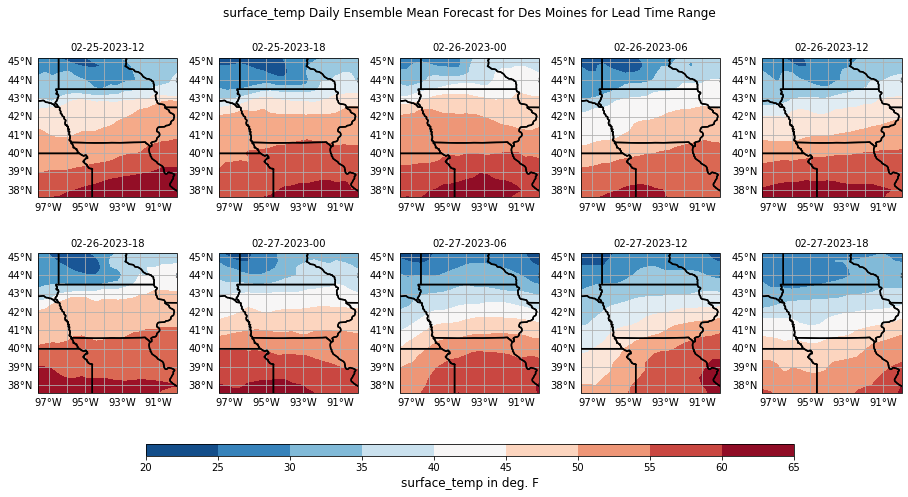

In [13]:
# DAILY ENSEMBLE MEAN MAPS ################################
# These maps are only provided for spefic time intervals,  NOT the entire forecast period


# data needs to be re-aggregated so it is able to be sliced over a 4x4 lat/lon grid

data_xr = xr.open_dataset(filename, filter_by_keys={'dataType': 'pf'}, engine='cfgrib')
data_xr_sel = data_xr.sel(latitude=slice(cities[user_input_loc]['latitude']+lat_range,cities[user_input_loc]['latitude']- lat_range),
                  longitude=slice((cities[user_input_loc]['longitude']-lon_range),(cities[user_input_loc]['longitude']+lon_range)))

# unit conversions based on re-aggregated data
if user_input_wx_var == 'surface_temp':
   data_xr_sel_2 = ((data_xr_sel - 273.15) * 9/5) + 32

elif user_input_wx_var == 'surface_pressure':
   data_xr_sel_2 = (data_xr_sel/100)

elif user_input_wx_var == 'precipitation':
   data_xr_sel_2 = data_xr_sel

elif user_input_wx_var == 'height500':
   data_xr_sel_2 = (data_xr_sel/10)

elif user_input_wx_var == 'surface_wind':
   data_xr_sel['result_wind'] = (xu.sqrt(data_xr_sel[wx_variables[user_input_wx_var]['ec_name_u']]**2 + 
                           data_xr_sel[wx_variables[user_input_wx_var]['ec_name_v']]**2)) *2.237
   data_xr_sel_2 = data_xr_sel


# ---------------- Daily Forecast Maps -----------------
# forecast maps are produced over a 4x4 grid surrounding the specified location

fig, ax = plot.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,8))
ax = ax.flatten()
ii =0
# subplots for each identified interval are defined
for a in range(start_plot,end_plot,1):
    lead_time = a
    day_fct = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].where(data_xr_sel_2.valid_time == data_xr_sel_2.valid_time[lead_time], drop=True).mean('number')
    day_fct = day_fct.mean('step')
    scale = '10m'
    states10 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lakes',
            scale=scale,
            facecolor='none',
            edgecolor='k')
    ax[ii].coastlines()
    fill = ax[ii].contourf(day_fct['longitude'], day_fct['latitude'], day_fct,cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    ax[ii].add_feature(states10, zorder=3, linewidth=1.5)
    ax[ii].add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    gl = ax[ii].gridlines(draw_labels=True)
    ax[ii].add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    ax[ii].set_title('{}'.format(data_xr_sel_2.step.valid_time.dt.strftime('%m-%d-%Y-%H').values[lead_time]), fontsize=10)
    ii = ii + 1

# Delete figure componets if needed
if cell_delete != 'NaN':
    fig.delaxes(ax[cell_delete])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.3, top=0.9, left=0.1, right=0.9,
                    wspace=0.3, hspace=0.3)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(fill, cax=cbar_ax,orientation='horizontal')

# Add a title at the top
plt.suptitle('{} Daily Ensemble Mean Forecast for {} for Lead Time Range'.format(user_input_wx_var, user_input_loc))
cbar.set_label('{} in {}'.format(user_input_wx_var, units), fontsize=12)

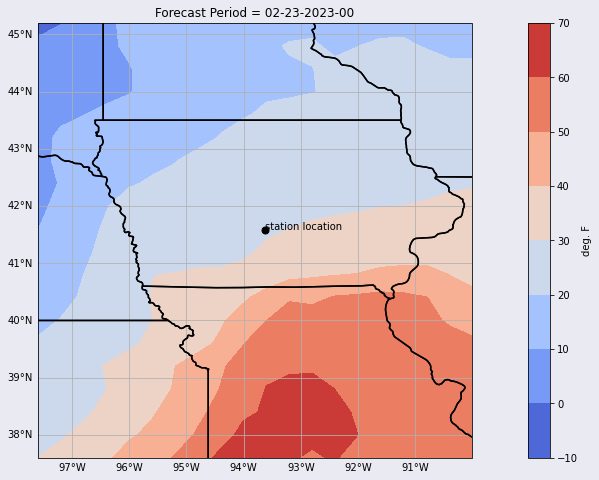

In [14]:
# ANIMATED FORECAST MAPS #######################

# data needs to be re-aggregated so it is able to be sliced over a 4x4 lat/lon grid

data_xr = xr.open_dataset(filename, filter_by_keys={'dataType': 'pf'}, engine='cfgrib')
data_xr_sel = data_xr.sel(latitude=slice(cities[user_input_loc]['latitude']+lat_range,cities[user_input_loc]['latitude']- lat_range),
                  longitude=slice((cities[user_input_loc]['longitude']-lon_range),(cities[user_input_loc]['longitude']+lon_range)))

# unit conversions based on re-aggregated data
if user_input_wx_var == 'surface_temp':
   data_xr_sel_2 = ((data_xr_sel - 273.15) * 9/5) + 32

elif user_input_wx_var == 'surface_pressure':
   data_xr_sel_2 = (data_xr_sel/100)

elif user_input_wx_var == 'precipitation':
   data_xr_sel_2 = data_xr_sel

elif user_input_wx_var == 'height500':
   data_xr_sel_2 = (data_xr_sel/10)

elif user_input_wx_var == 'surface_wind':
   data_xr_sel['result_wind'] = (xu.sqrt(data_xr_sel[wx_variables[user_input_wx_var]['ec_name_u']]**2 + 
                           data_xr_sel[wx_variables[user_input_wx_var]['ec_name_v']]**2)) *2.237
   data_xr_sel_2 = data_xr_sel

# Take the ensemble mean for each grid point over all ensemble members
anim_df = data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].mean('number')

# set mapping projection
proj = ccrs.PlateCarree()

# set cooler map
cmap = plt.get_cmap('coolwarm')

# identify lat/lon points for grid
lon = anim_df['longitude']
lat = anim_df['latitude']

# set up configurations and parameters for mapping
fig, ax = plt.subplots(figsize=(20,8),subplot_kw=dict(projection=proj))
fill = ax.contourf(lon, lat, anim_df[0,:,:],cmap = cmap,
                             add_colorbar=False, transform=proj)
ax.plot(cities[user_input_loc]['longitude'], cities[user_input_loc]['latitude'], 'ko', markersize=7, transform=ccrs.Geodetic())
ax.text(cities[user_input_loc]['longitude'], cities[user_input_loc]['latitude'], 'station location', transform=ccrs.Geodetic())
ax.coastlines()
scale = '10m'
states10 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lakes',
            scale=scale,
            facecolor='none',
            edgecolor='k')
ax.add_feature(states10, zorder=3, linewidth=1.5)
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
gl = ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
cb =fig.colorbar(fill)
cb.set_label("{}".format(units))
fig.patch.set_facecolor('#EAEAF2')

# define function to animate maps for all forecast periods
def animate(frame):
    ax.contourf(lon, lat, anim_df[frame,:,:],transform= proj,cmap=cmap)
    ax.set_title("Forecast Period = " + str(anim_df.step.valid_time.dt.strftime('%m-%d-%Y-%H').values[frame])) # dt.strftime('%m-%d-%Y')   
    
nframes = anim_df['step'].size # get number of forecast periods - pass as number of frames into animation 

# Utilize animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=nframes,  # identify frames in animation
    interval=1000,    # ms between frames - set to 1 second intervals 
)

plt.draw()
plt.show()

HTML(ani.to_jshtml()) # generate html representation of the animation

#### Single Time Period Forecast and Analysis ####

In [15]:
############################### The following code is for a specific time period #########################

###### USER INPUT NEEDED #########
nrows=1
ncols=1
cell_delete = 'NaN'

# Forecast time criteria

month_id =2 # forecast month desired

day_id = 28 # forecast day desired

hour_id = 12 # forecast hour desired

##### The below input parameters follow the same notation that is used in Part 1 for the full forecast period #####

# percentiles based on ensemble members
qt_dims = ('number')
qt_upper_lim = 0.9
qt_lower_lim = 0.1

# data comparisions
data_comp_type = 'less'
data_thres_val_array= [20,30,40] # values for comparision
data_thres_val = 0

# STDEV values for comparison
stdev_values = [0,3,5,8]
spread_values = [0,6,12,18]

# define units based on input parameter
units = 'deg. F'

# grid range used for mapping
lat_range = 4
lon_range = 4

In [16]:
################### Isolate specific time period ################

# Convert data to Xarray
data_xr = xr.open_dataset(filename, filter_by_keys={'dataType': 'pf'}, engine='cfgrib')


# Isolate data for specific lat/lon point based on user input of city location
data_xr_sel = data_xr.sel(latitude = cities[user_input_loc]['latitude'] , longitude = cities[user_input_loc]['longitude'],
                          method='nearest')


# Unit conversions for selected weather variable
if user_input_wx_var == 'surface_temp':
   data_xr_sel_2 = ((data_xr_sel - 273.15) * 9/5) + 32

elif user_input_wx_var == 'surface_pressure':
   data_xr_sel_2 = (data_xr_sel/100)

elif user_input_wx_var == 'precipitation':
   data_xr_sel_2 = data_xr_sel

elif user_input_wx_var == 'height500':
   data_xr_sel_2 = (data_xr_sel/10)

elif user_input_wx_var == 'surface_wind':
   data_xr_sel['result_wind'] = (xu.sqrt(data_xr_sel[wx_variables[user_input_wx_var]['ec_name_u']]**2 + 
                           data_xr_sel[wx_variables[user_input_wx_var]['ec_name_v']]**2)) *2.237
   data_xr_sel_2 = data_xr_sel

# Dictionary of weather variables
wx_variables = {
    'surface_temp': {
        'var_name' : '2t',
        'ec_name' : 't2m',
        'ec_name_2': 't2m',
    },
    'surface_wind':{
        'var_name_u': '10u',
        'ec_name_u': 'u10',
        'var_name_v': '10v',
        'ec_name_v': 'v10',
        'var_name': 'wind_speed',
        'ec_name_2': 'result_wind',
    },
    'surface_pressure': {
        'var_name' : 'msl',
        'ec_name' : 'msl',
        'ec_name_2': 'msl',
    },
    'precipitation': {
        'var_name' : 'tcwv', # total column water vapor
        'ec_name' : 'tcwv',
        'ec_name_2': 'tcwv',
    },
    'height500': {
        'var_name' : 'gh', 
        'ec_name' : 'gh',
        'ec_name_2': 'gh',
    },
}

# Script to properly extract desired time frame

for a in range(0,len(data_xr_sel_2[wx_variables[user_input_wx_var]['ec_name_2']].step)):
    time_id = data_xr_sel_2.isel(step = a)
    if time_id.valid_time.dt.month.values == month_id:
        if time_id.valid_time.dt.day.values == day_id:
            if time_id.valid_time.dt.hour.values == hour_id:
                fct_step_id = a

day_fct = data_xr_sel_2.isel(step = fct_step_id)

print("the desired forecast date/time is =" ,day_fct.valid_time.values)

# print array of data for date stamp
day_fct

the desired forecast date/time is = 2023-02-28T12:00:00.000000000


<xarray.Dataset>
Dimensions:            (number: 50)
Coordinates:
  * number             (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    time               datetime64[ns] ...
    step               timedelta64[ns] 5 days 12:00:00
    heightAboveGround  float64 ...
    latitude           float64 41.6
    longitude          float64 -93.6
    valid_time         datetime64[ns] 2023-02-28T12:00:00
Data variables:
    t2m                (number) float32 22.99 24.16 24.05 ... 28.82 18.5 29.26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-02-23T13:54 GRIB to CDM+CF via cfgrib-0.9.1...

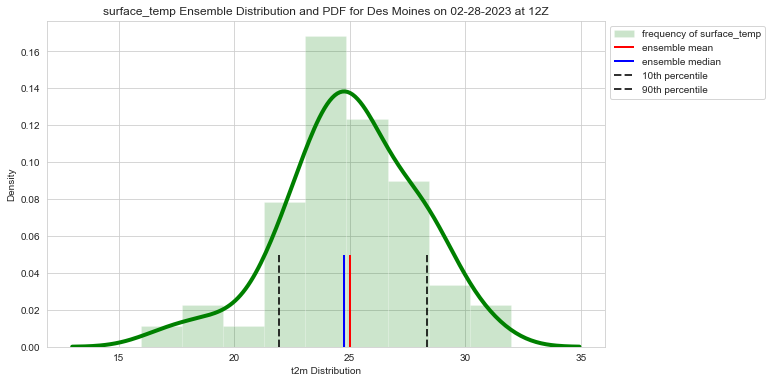

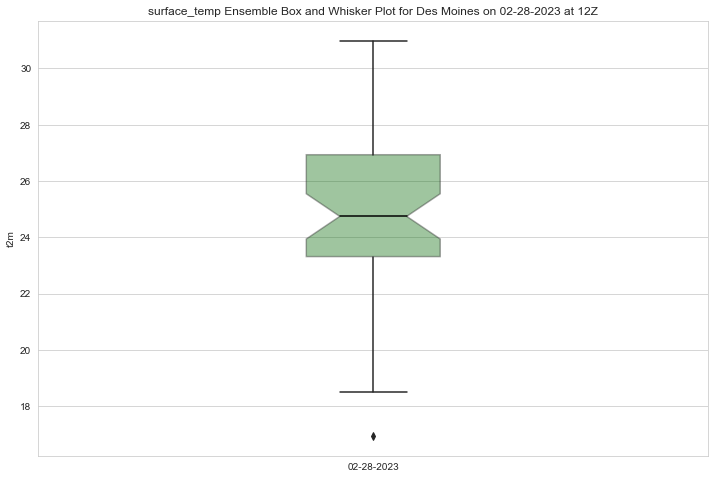

+------------+----------+----------------------------------------+----------------------------------------+----------------------------------------+
|  fct day   | fct hour | probability less than 20 deg. F as (%) | probability less than 30 deg. F as (%) | probability less than 40 deg. F as (%) |
+------------+----------+----------------------------------------+----------------------------------------+----------------------------------------+
| 02-28-2023 |    12    |                  3.96                  |                 95.93                  |                 100.0                  |
+------------+----------+----------------------------------------+----------------------------------------+----------------------------------------+
+------------+----------+---------------+-----------------+----------------+-----------------+-----------------+-----------------+
|  fct day   | fct hour | Ensemble Mean | Ensemble Median | Ensemble STDEV | 10th Percentile | 90th Percentile | Quantile Sp

In [17]:
#1) Probability Density Function and Historgram #########################

# this visualization provides a visual distirbution for the given input parameter. The PDF also helps identify the type of 
# distribution. With 50 ensemble members, the distribution for most cases should be a normal distribution
day_fct_mean = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].mean('number')
day_fct_median = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].median('number')
day_qt_values = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].values
quantiles = (qt_lower_lim, qt_upper_lim)
qt_dims = ('number')

day_qt_vals = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].quantile(quantiles, dim=qt_dims)

y_max_lim = 0.05
bins = np.linspace(day_fct[wx_variables[user_input_wx_var]['ec_name_2']].min() -1, day_fct[wx_variables[user_input_wx_var]['ec_name_2']].max() + 1, 10)

# seaborn plot using used for this histogram/PDF
plot.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.distplot(day_fct[wx_variables[user_input_wx_var]['ec_name_2']], hist=True, kde=True, bins = bins, label="frequency of {}".format(user_input_wx_var),
                 hist_kws=dict(alpha=0.2),
                 color = 'green', 
                 kde_kws={'linewidth': 4})

# vertical lines in plot are used for comparision (ensemble median, mean, 10th/90th percentiles)
plot.vlines(day_fct_mean,linewidth = 2, ymin = 0, ymax =y_max_lim, colors = 'red', label = 'ensemble mean')
plot.vlines(day_fct_median, ymin = 0, linewidth = 2, ymax = y_max_lim, colors = 'blue', label = 'ensemble median')
plot.vlines(day_qt_vals[0],linewidth = 2, ymin = 0, ymax = y_max_lim, colors = 'black', label ='10th percentile',
            alpha=0.8, linestyle='dashed')
plot.vlines(day_qt_vals[1], ymin = 0, linewidth = 2, ymax = y_max_lim, colors = 'black', label = '90th percentile',
            alpha=0.8, linestyle='dashed')

plot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title("{} Ensemble Distribution and PDF for {} on {} at {}Z".format(user_input_wx_var,user_input_loc, day_fct.valid_time.dt.strftime('%m-%d-%Y').values, day_fct.valid_time.dt.strftime('%H').values))
plot.xlabel('{} Distribution'.format(wx_variables[user_input_wx_var]['ec_name_2']))
plot.ylabel('Density')

plot.show()



#2) Box and Whisker Plot ###################################
# box and whisker is a single plot to better demonstrate distibution and outlier values

plt.figure(figsize=(12,8))
ax = sns.boxplot(
    y=day_fct[wx_variables[user_input_wx_var]['ec_name_2']],
    notch=True, showcaps=True,
     width=0.2, color="green", boxprops=dict(alpha=.4),
    medianprops={"color": "black"},
)

plt.title("{} Ensemble Box and Whisker Plot for {} on {} at {}Z".format(user_input_wx_var,user_input_loc,day_fct.valid_time.dt.strftime('%m-%d-%Y').values, day_fct.valid_time.dt.strftime('%H').values))

ax.set_xticks([0])
ax.set_xticklabels([day_fct.valid_time.dt.strftime('%m-%d-%Y').values])
plt.show()



# 3) Distribution and Risk Table #####################################
# This table provides the same information as the one above for the full period, but now for only a single forecast period

probTable = PrettyTable(["fct day","fct hour" ,"probability {} than {} {} as (%)".format(data_comp_type, data_thres_val_array[0], units),
                        "probability {} than {} {} as (%)".format(data_comp_type, data_thres_val_array[1], units),
                        "probability {} than {} {} as (%)".format(data_comp_type, data_thres_val_array[2], units)])
#Color
R = "\033[0;31;40m" #RED
G = "\033[0;32;40m" # GREEN
Y = "\033[0;33;40m" # Yellow
B = "\033[0;34;40m" # Blue
N = "\033[0m" # Reset

# identify statistical breakdown for time period over all ensemble members
fct_total_mean = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].mean('number')
fct_total_median =  day_fct[wx_variables[user_input_wx_var]['ec_name_2']].median('number')
fct_total_std = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].std('number')

# probability calculations
for b in range(0,len(data_thres_val_array)):
    zscore_wx = ((data_thres_val_array[b]-fct_total_mean)/fct_total_std)
    prob_stat =(1-stats.norm.cdf(zscore_wx))*100
    prob_stat =round(prob_stat,2)
        
    if data_comp_type == 'greater':
            zscore_prob_str = str(prob_stat)
            zscore_prob = prob_stat
            zscore_prob =round( zscore_prob,2)

    elif data_comp_type == 'less':
            prob_lower_stat = 100 - prob_stat
            prob_lower_stat =round(prob_lower_stat,2)
            zscore_prob_str = str(prob_lower_stat)
            zscore_prob = 100 - prob_stat
            zscore_prob =round( zscore_prob,2)
    
    if b == 0:
            if zscore_prob >80:
                zscore_prob_low = R+zscore_prob_str+N
            elif (zscore_prob >=60) & (zscore_prob <80):
                 zscore_prob_low = Y+zscore_prob_str+N 
            else:
                zscore_prob_low = zscore_prob_str
    if b == 1:
            if zscore_prob >80:
                zscore_prob_mid = R+zscore_prob_str+N
            elif (zscore_prob >=60) & (zscore_prob <80):
                 zscore_prob_mid = Y+zscore_prob_str+N 
            else:
                zscore_prob_mid = zscore_prob_str
    if b == 2:
            if zscore_prob >80:
                zscore_prob_high = R+zscore_prob_str+N
            elif (zscore_prob >=60) & (zscore_prob <80):
                 zscore_prob_high = Y+zscore_prob_str+N 
            else:
                zscore_prob_high = zscore_prob_str
# Add rows
probTable.add_row([day_fct.valid_time.dt.strftime('%m-%d-%Y').values, day_fct.valid_time.dt.strftime('%H').values,zscore_prob_low, zscore_prob_mid, zscore_prob_high])


print(probTable)

# 4) Statistical Summary Table ########################################
# # This table provides the same information as the one above for the full period , but now only for the single forecast period
statsTable = PrettyTable(["fct day","fct hour","Ensemble Mean", "Ensemble Median","Ensemble STDEV", "10th Percentile", 
                        "90th Percentile", "Quantile Spread"])

#Color
R = "\033[0;31;40m" #RED
G = "\033[0;32;40m" # GREEN
Y = "\033[0;33;40m" # Yellow
B = "\033[0;34;40m" # Blue
N = "\033[0m" # Reset


# identify statistical breakdown for time period over all ensemble members
fct_total_mean = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].mean('number')
fct_total_median =  day_fct[wx_variables[user_input_wx_var]['ec_name_2']].median('number')
fct_total_std = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].std('number')

qt_dims = ('number')
qt_upper_lim = 0.9
qt_lower_lim = 0.1
quantiles = (qt_lower_lim, qt_upper_lim)
fct_total_quant = day_fct[wx_variables[user_input_wx_var]['ec_name_2']].quantile(quantiles, dim=qt_dims)
fct_total_quant_diff = (fct_total_quant[1] - fct_total_quant[0])

fct_total_mean = np.round_(fct_total_mean.values,decimals = 2)
fct_total_median = np.round_(fct_total_median.values,decimals = 2)
fct_total_std_2 = np.round_(fct_total_std.values,decimals = 2)
fct_total_quant = np.round_(fct_total_quant.values,decimals = 2)
fct_total_quant_diff_2 = np.round_(fct_total_quant_diff.values,decimals = 2)

# standard deviation among model members

if ((fct_total_std.values  >= stdev_values[0]) & (fct_total_std.values < stdev_values[1])):
        variance_score = fct_total_std_2
    
elif((fct_total_std.values >= stdev_values[1]) & (fct_total_std.values < stdev_values[2])):
        variance_score = G+str(fct_total_std_2)+N
    
elif((fct_total_std.values >= stdev_values[2]) & (fct_total_std.values < stdev_values[3])):
        variance_score = Y+str(fct_total_std_2)+N
    
elif(fct_total_std.values >= stdev_values[3]):
        variance_score = R+str(fct_total_std_2)+N
    
# model spread identification

if (fct_total_quant_diff.values  >= spread_values[0]) & (fct_total_quant_diff.values < spread_values[1]):
        spread_score = fct_total_quant_diff_2
    
elif (fct_total_quant_diff.values  >= spread_values[1]) & (fct_total_quant_diff.values < spread_values[2]):
        spread_score = G+str(fct_total_quant_diff_2)+N
    
elif (fct_total_quant_diff.values  >= spread_values[2]) & (fct_total_quant_diff.values < spread_values[3]):
        spread_score = Y+str(fct_total_quant_diff_2)+N
    
elif (fct_total_quant_diff.values  >= spread_values[3]):
        spread_score = R+str(fct_total_quant_diff_2)+N


# Add rows

statsTable.add_row([day_fct.valid_time.dt.strftime('%m-%d-%Y').values, day_fct.valid_time.dt.strftime('%H').values, fct_total_mean, fct_total_median, variance_score,
                        fct_total_quant[0], fct_total_quant[1], spread_score])
    

print(statsTable)